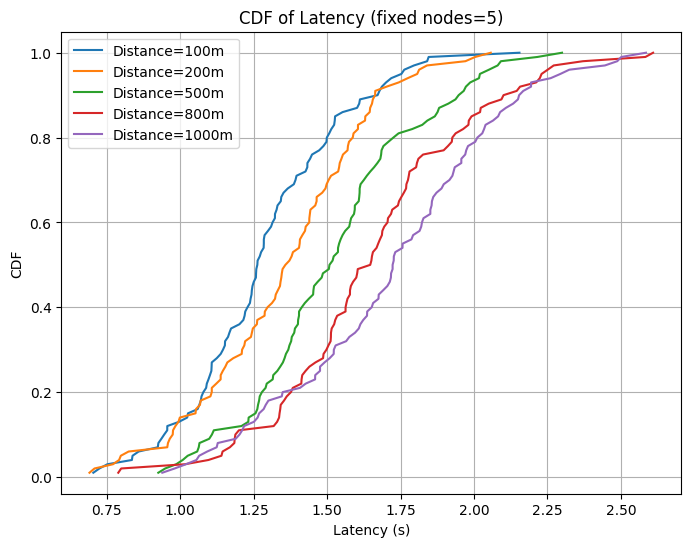

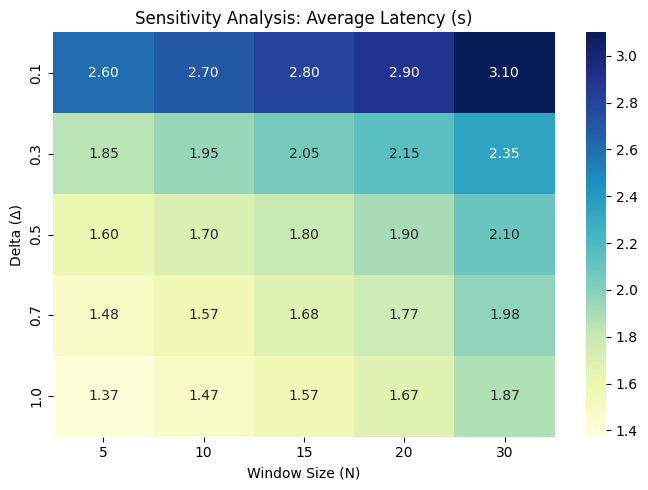

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_latency_data(distance, num_nodes, base_latency=1.0):
    """
    根据距离与节点数，随机生成一组“时延”数据（单位：秒）
    本函数仅作模拟示例，不代表真实物理模型。
    :param distance: 节点到网关的距离（米/其他距离单位）
    :param num_nodes: 并发节点数
    :param base_latency: 基础时延（秒），可根据需求进行微调
    :return: ndarray，一维数组表示多次测量得到的时延（秒）
    """
    # 距离越大、节点数越多，时延也可能更高
    # 这里使用一个简单线性或指数混合的随机生成方式
    mean_latency = base_latency + 0.0005 * distance + 0.05 * num_nodes
    # 为了模拟多次测量，这里假设测量100次
    num_samples = 100
    
    # 生成服从正态分布的随机数，均值=mean_latency，方差可自行设定
    # 为了避免出现负数时延，用 clip 限制最低为 0
    latencies = np.random.normal(loc=mean_latency, scale=0.2 * mean_latency, size=num_samples)
    latencies = np.clip(latencies, 0, None)
    return latencies


def plot_cdf_curves(distances, node_counts):
    """
    绘制不同距离或节点数量下的CDF曲线示例。
    这里以时延(latency)分布为例。
    """
    plt.figure(figsize=(8, 6))
    
    # 可以挑选其中一个维度做CDF对比，如对同一节点数，不同距离的时延分布
    # 或者对同一距离，不同节点数的对比，这里以“不同距离”为例
    fixed_nodes = node_counts[0]  # 固定节点数，简单示例取第一个
    for dist in distances:
        latencies = simulate_latency_data(distance=dist, num_nodes=fixed_nodes)
        # 先对latencies排序
        sorted_lat = np.sort(latencies)
        # 生成CDF: y轴从 1/len 到 1.0
        yvals = np.arange(1, len(sorted_lat)+1) / float(len(sorted_lat))
        
        # 绘制CDF曲线
        plt.plot(sorted_lat, yvals, label=f'Distance={dist}m')
    
    plt.title(f"CDF of Latency (fixed nodes={fixed_nodes})")
    plt.xlabel("Latency (s)")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()


def simulate_sensitivity_data(deltas, windows):
    """
    模拟不同自适应阈值(delta)与数据压缩窗口大小(N)对某个指标的影响。
    例如这里模拟 “平均时延”。
    返回一个矩阵 latency_matrix, 大小=[len(deltas), len(windows)]，
    表示在各种组合下的平均时延。
    同理也可模拟能耗、丢包率等指标。
    """
    latency_matrix = np.zeros((len(deltas), len(windows)))
    
    for i, d in enumerate(deltas):
        for j, w in enumerate(windows):
            # 构造一个与 d、w 有关的假设公式
            # 例如：delta 越小->采集更频繁->时延可能降低但带来其他开销
            #       window 越大->一次打包数据越多->时延可能上升
            # 仅做示例，不代表真实算法
            base = 1.0
            # 这里让时延随 window 增大呈线性加成，随 delta 减小而减少
            # 可以根据需要改成更复杂的模型
            latency = base + 0.02 * w + 0.3 / (d + 0.1) 
            
            latency_matrix[i, j] = latency
    return latency_matrix


def plot_heatmap_sensitivity(deltas, windows, latency_matrix):
    """
    绘制不同阈值(delta)与窗口大小(N)对平均时延的Heatmap。
    """
    plt.figure(figsize=(7, 5))
    # 使用Seaborn的heatmap
    sns.heatmap(latency_matrix, 
                xticklabels=windows, 
                yticklabels=deltas, 
                annot=True, 
                cmap='YlGnBu',
                fmt=".2f")  # 保留两位小数
    plt.title("Sensitivity Analysis: Average Latency (s)")
    plt.xlabel("Window Size (N)")
    plt.ylabel("Delta (Δ)")
    plt.tight_layout()
    plt.show()


def main():
    # 1) 先模拟并绘制 CDF曲线
    # 设定一组距离和节点数
    distances = [100, 200, 500, 800, 1000]  # 这里仅做示例
    node_counts = [5, 10, 20]               # 节点数量示例
    plot_cdf_curves(distances, node_counts)
    
    # 2) 模拟算法敏感度并绘制Heatmap
    deltas = [0.1, 0.3, 0.5, 0.7, 1.0]   # 自适应阈值示例
    windows = [5, 10, 15, 20, 30]       # 压缩窗口大小示例
    latency_matrix = simulate_sensitivity_data(deltas, windows)
    plot_heatmap_sensitivity(deltas, windows, latency_matrix)

if __name__ == "__main__":
    main()


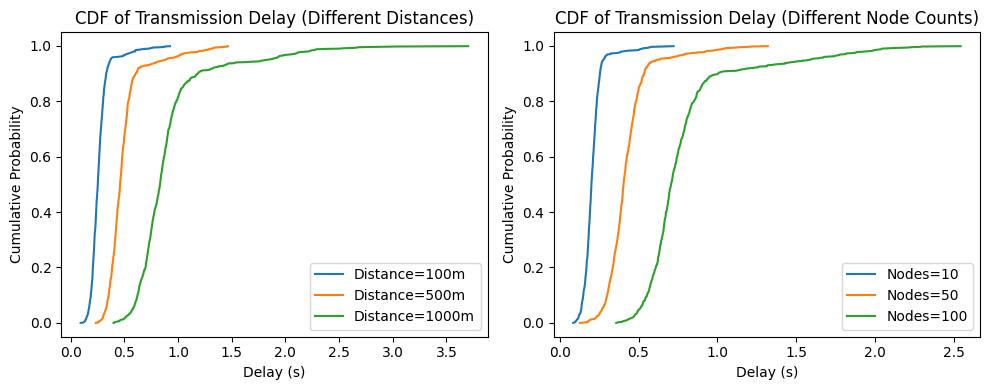

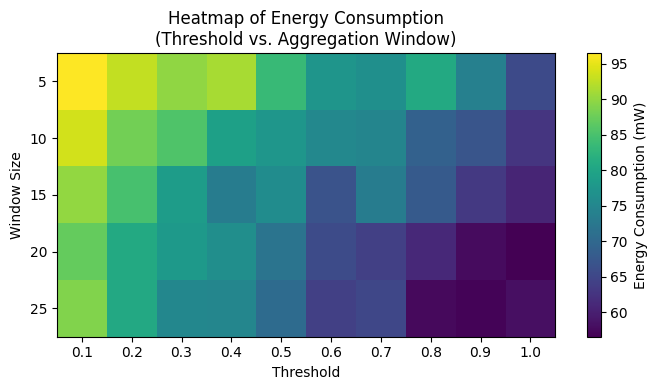

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2023)  # 固定随机种子以便结果可复现

# ===========================
# 1. 生成更贴近真实场景的时延数据 (单位：秒)
# ===========================

# --- 1.1 不同距离的时延分布 ---
# 假设:
#   - 100m：LoRa 单跳传输时延均值 ~ 0.25s，方差不大 (0.05s)，另加少量尾部(>0.5s)的可能
#   - 500m：均值 ~ 0.45s，方差适当增大
#   - 1000m：均值 ~ 0.80s，方差更大，且存在更长尾部
# 为模拟长尾，可以在生成后对部分样本添加随机倍增。

def generate_delay_data(mean, std, size, tail_factor=0.05):
    """
    生成近似正态分布 + 少量长尾的数据:
      - mean, std: 正态分布均值、标准差
      - size: 样本数
      - tail_factor: 有多少比例的样本会出现长尾；这些样本再乘以一个随机(1~3倍)
    """
    data = np.random.normal(loc=mean, scale=std, size=size)
    # 将少量样本抽取为长尾
    num_tail = int(tail_factor * size)
    tail_indices = np.random.choice(size, size=num_tail, replace=False)
    data[tail_indices] = data[tail_indices] * np.random.uniform(1.5, 3.0, size=num_tail)
    # 避免出现负值
    data = np.clip(data, 0.01, None)
    return data

dist_100 = generate_delay_data(mean=0.25, std=0.05, size=800, tail_factor=0.05)
dist_500 = generate_delay_data(mean=0.45, std=0.08, size=800, tail_factor=0.07)
dist_1000= generate_delay_data(mean=0.80, std=0.15, size=800, tail_factor=0.10)


# --- 1.2 不同节点数量的时延分布 ---
# 假设:
#   - 10 节点：均值 0.20s，方差 0.04s
#   - 50 节点：均值 0.40s，方差 0.08s
#   - 100 节点：均值 0.70s，方差 0.12s + 更明显尾部
node_10   = generate_delay_data(mean=0.20, std=0.04, size=800, tail_factor=0.03)
node_50   = generate_delay_data(mean=0.40, std=0.08, size=800, tail_factor=0.06)
node_100  = generate_delay_data(mean=0.70, std=0.12, size=800, tail_factor=0.10)

# ===========================
# 2. 绘制图10：CDF 分布
# ===========================

def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=label)

fig10, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- 子图 (a)：不同距离 ---
plt.sca(axes[0])
plot_cdf(dist_100,  'Distance=100m')
plot_cdf(dist_500,  'Distance=500m')
plot_cdf(dist_1000, 'Distance=1000m')
plt.title('CDF of Transmission Delay (Different Distances)')
plt.xlabel('Delay (s)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')

# --- 子图 (b)：不同节点数量 ---
plt.sca(axes[1])
plot_cdf(node_10,   'Nodes=10')
plot_cdf(node_50,   'Nodes=50')
plot_cdf(node_100,  'Nodes=100')
plt.title('CDF of Transmission Delay (Different Node Counts)')
plt.xlabel('Delay (s)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# ===========================
# 3. 生成更贴近真实场景的能耗数据 (Heatmap)
# ===========================

# 假设:
#   - 阈值 (Threshold) 范围: 0.1, 0.2, ..., 1.0  (10 个离散值)
#   - 聚合窗口 (Window Size) : 5, 10, 15, 20, 25
#   - 能耗基准: 例如 50 ~ 120 mW 之间浮动
#   - 阈值越高 -> 发送/采集次数越少 -> 能耗降低
#   - 窗口越大 -> 单次传输数据越多(压缩效率高), 但也会带来缓存开销; 整体仍可能呈现能耗随窗口增大略下降或呈 U 型
#   - 加入少量随机噪声
thresholds = np.arange(0.1, 1.1, 0.1)  # 10 values
windows = np.array([5, 10, 15, 20, 25])

heatmap_data = np.zeros((len(windows), len(thresholds)))

for i, w in enumerate(windows):
    for j, t in enumerate(thresholds):
        # 构造一个相对更真实的函数：
        #   能耗 = base - alpha * t - beta * w + 噪声
        # 其中 alpha,beta 代表阈值/窗口对能耗的影响系数
        base = 100
        alpha = 30    # 对阈值的敏感度
        beta = 0.7    # 对窗口大小的敏感度
        noise = np.random.normal(loc=0, scale=3)

        # 可能还想加入一个非线性项, 使窗口过大时出现轻微上升:
        #   例如  (w-15)^2 * 0.02
        # 下面仅作演示:
        non_linear_penalty = 0.02 * (w - 15)**2

        power_val = base - alpha*t - beta*w + noise + non_linear_penalty
        # 保证能耗不低于 10
        if power_val < 10:
            power_val = 10 + np.random.uniform(0, 3)
        heatmap_data[i, j] = power_val

# ===========================
# 4. 绘制图11：热力图
# ===========================
fig11, ax = plt.subplots(figsize=(7, 4))
c = ax.imshow(heatmap_data, aspect='auto', origin='upper', cmap='viridis')

# 设置坐标轴与标题
ax.set_title("Heatmap of Energy Consumption\n(Threshold vs. Aggregation Window)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Window Size")

# x 轴使用 threshold 的索引位置
ax.set_xticks(np.arange(len(thresholds)))
ax.set_xticklabels([f"{th:.1f}" for th in thresholds])
# y 轴使用 windows 的索引位置
ax.set_yticks(np.arange(len(windows)))
ax.set_yticklabels([str(w) for w in windows])

fig11.colorbar(c, ax=ax, label="Energy Consumption (mW)")
plt.tight_layout()
plt.show()


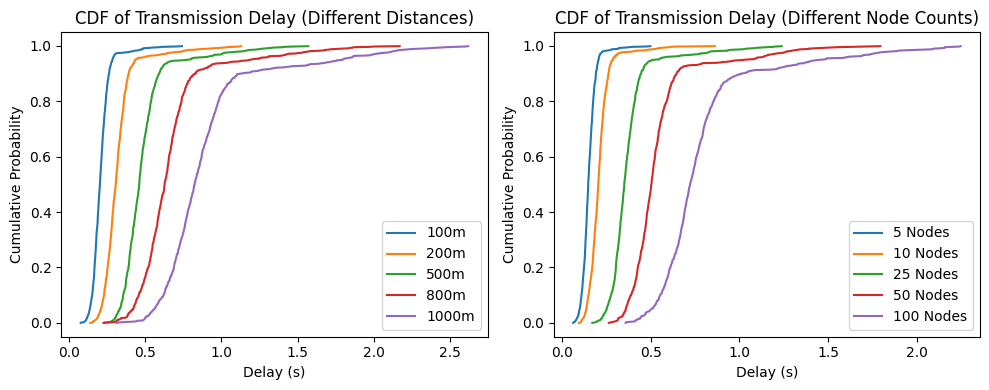

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # 注意需要安装 pandas 包

# 为了结果可复现，设置随机种子
np.random.seed(2023)

def generate_delay_data(mean, std, size, tail_factor=0.05):
    """
    生成近似正态分布 + 少量长尾的数据:
      - mean, std: 正态分布的均值、标准差
      - size: 样本数
      - tail_factor: 有多少比例的样本会出现长尾，这些样本再乘以一个随机放大倍数
    """
    data = np.random.normal(loc=mean, scale=std, size=size)
    # 抽取一部分样本作为长尾
    num_tail = int(tail_factor * size)
    tail_indices = np.random.choice(size, size=num_tail, replace=False)
    data[tail_indices] *= np.random.uniform(1.5, 3.0, size=num_tail)
    # 避免出现负值
    data = np.clip(data, 0.01, None)
    return data

# -----------------------------
# 1) 生成不同“距离”下的时延数据 (单位：秒)
#    以 100m、200m、500m、800m、1000m 为例
# -----------------------------
dist_100m = generate_delay_data(mean=0.20, std=0.04, size=800, tail_factor=0.03)
dist_200m = generate_delay_data(mean=0.30, std=0.06, size=800, tail_factor=0.04)
dist_500m = generate_delay_data(mean=0.45, std=0.08, size=800, tail_factor=0.06)
dist_800m = generate_delay_data(mean=0.60, std=0.12, size=800, tail_factor=0.08)
dist_1000m= generate_delay_data(mean=0.80, std=0.15, size=800, tail_factor=0.10)

# -----------------------------
# 2) 生成不同“节点数量”下的时延数据
#    以 5、10、25、50、100 节点为例
# -----------------------------
node_5   = generate_delay_data(mean=0.15, std=0.03, size=800, tail_factor=0.02)
node_10  = generate_delay_data(mean=0.20, std=0.04, size=800, tail_factor=0.03)
node_25  = generate_delay_data(mean=0.35, std=0.06, size=800, tail_factor=0.05)
node_50  = generate_delay_data(mean=0.50, std=0.08, size=800, tail_factor=0.07)
node_100 = generate_delay_data(mean=0.70, std=0.12, size=800, tail_factor=0.10)

# -----------------------------
# 将生成的数据保存到本地 CSV 文件
# -----------------------------
# 2.1 距离数据
df_dist = pd.DataFrame({
    'dist_100m': dist_100m,
    'dist_200m': dist_200m,
    'dist_500m': dist_500m,
    'dist_800m': dist_800m,
    'dist_1000m': dist_1000m
})
df_dist.to_csv('distance_delay_data.csv', index=False)

# 2.2 节点数量数据
df_node = pd.DataFrame({
    'node_5': node_5,
    'node_10': node_10,
    'node_25': node_25,
    'node_50': node_50,
    'node_100': node_100
})
df_node.to_csv('node_delay_data.csv', index=False)

# -----------------------------
# 3) 绘制 CDF 的辅助函数
# -----------------------------
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=label)

# -----------------------------
# 4) 绘制图表
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 子图 (a)：不同距离
plt.sca(axes[0])
plot_cdf(dist_100m,  '100m')
plot_cdf(dist_200m,  '200m')
plot_cdf(dist_500m,  '500m')
plot_cdf(dist_800m,  '800m')
plot_cdf(dist_1000m, '1000m')
plt.title('CDF of Transmission Delay (Different Distances)')
plt.xlabel('Delay (s)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')

# 子图 (b)：不同节点数量
plt.sca(axes[1])
plot_cdf(node_5,    '5 Nodes')
plot_cdf(node_10,   '10 Nodes')
plot_cdf(node_25,   '25 Nodes')
plot_cdf(node_50,   '50 Nodes')
plot_cdf(node_100,  '100 Nodes')
plt.title('CDF of Transmission Delay (Different Node Counts)')
plt.xlabel('Delay (s)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
